# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

## Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

- Thumbs up:  Increase the volume
- Thumbs down: Decrease the volume
- Left swipe: 'Jump' backwards 10 seconds
- Right swipe: 'Jump' forward 10 seconds  
- Stop: Pause the movie

Each video is a sequence of 30 frames (or images).

## Obectives
Need to accomplish the following in the project:

1. Generator:  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

2. Model: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

3. Write up: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model. 

## Importing Important libraies

In [ ]:
!pip install scipy

In [ ]:
!pip install Pillow

In [52]:
import numpy as np
import os
from scipy import misc
from imageio import imread
from skimage.transform import resize
import datetime
import os
from sys import getsizeof
import cv2
import matplotlib.pyplot as plt
% matplotlib inline
import warnings
warnings.filterwarnings("ignore")

## importing Few More libraries needed for the model building.
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout

We set the random seed so that the results don't vary drastically.

In [53]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [54]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
else:
    print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [55]:
## Checking the GPU configuration
!nvidia-smi


Mon Nov 15 11:29:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    38W / 250W |   2625MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [57]:
train_doc = np.random.permutation(open('/content/drive/MyDrive/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/drive/MyDrive/Project_data/val.csv').readlines())
batch_size = 10

### Funtion for Plotting Training/Validation Accuracies/losses

In [58]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])
    axes[0].title.set_text("Train loss vs Validation loss")

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    axes[1].title.set_text("Train accuracy vs Validation accuracy")
    plt.show()
    

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

### Function for initializing and preprocessing

In [59]:
# Parameters initialization
image_width = 120   # X dimension of the image
image_height = 120   # Y dimesnion of the image
total_frames = 30  # lenght of the video frames
channels = 3 # numbe rof channels in images 3 for color(RGB) and 1 for Gray


In [60]:
# Helper function to generate a random affine transform on the iamge
def get_random_affine():
    dx, dy = np.random.randint(-1.7, 1.8, 2)
    AF = np.float32([[1, 0, dx], [0, 1, dy]])
    return AF

# Helper function to initialize all the batch image data and labels
def init_batch_data(batch_size):
    batch_data = np.zeros((batch_size, total_frames, image_width, image_height, channels)) 
    batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
    return batch_data, batch_labels

### Function for generator

In [61]:
def generator(source_path, folder_list, batch_size, augument_false=False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            # you yield the batch_data and the batch_labels, remember what does yield do
            yield load_batch_images(source_path, folder_list, batch, batch_size, t,augument_false)
            

        
        # Code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size*num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            yield load_batch_images(source_path, folder_list, batch, batch_size, t,augument_false)

In [62]:
def load_batch_images(source_path, folder_list, batch_num, batch_size, t,augument_false):
    
    batch_data,batch_labels = init_batch_data(batch_size)
    
    # We will also build an augumented batch data with affine transformation
    batch_data_aug,batch_labels_aug = init_batch_data(batch_size)
    
    
    #create a list of image numbers you want to use for a particular video using full frames
    img_idx = [x for x in range(0, total_frames)] 

    for folder in range(batch_size): # iterate over the batch_size
        # read all the images in the folder
        imgs = sorted(os.listdir(source_path+'/'+ t[folder + (batch_num*batch_size)].split(';')[0])) 
        # Generate a random affine to be used in image transformation for buidling agumented data set
        AF = get_random_affine()
        
        #  Iterate over the frames/images of a folder to read them in
        for idx, item in enumerate(img_idx): 
            image = imread(source_path+'/'+ t[folder + (batch_num*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
            #crop the images and resize them. Note that the images are of 2 different shape 
            #and the conv3D will throw error if the inputs in a batch have different shapes 
            if image.shape[0] != image.shape[1]:
                image=image[0:120,20:140]
             
            resized = cv2.resize(image, (image_height,image_width), interpolation = cv2.INTER_AREA) 
          
            #Normalize data

            batch_data[folder,idx,:,:,0] = cv2.normalize(resized[:,:,0],  None, 0.00, 1.00, cv2.NORM_MINMAX)
            batch_data[folder,idx,:,:,1] = cv2.normalize(resized[:,:,1],  None, 0.00, 1.00, cv2.NORM_MINMAX)
            batch_data[folder,idx,:,:,2] = cv2.normalize(resized[:,:,2],  None, 0.00, 1.00, cv2.NORM_MINMAX)
            
            #Data with affine transformation
            affined = (cv2.warpAffine(resized, AF, (resized.shape[0], resized.shape[1])))

            batch_data[folder,idx,:,:,0] = cv2.normalize(affined[:,:,0],  None, 0.00, 1.00, cv2.NORM_MINMAX)
            batch_data[folder,idx,:,:,1] = cv2.normalize(affined[:,:,1],  None, 0.00, 1.00, cv2.NORM_MINMAX)
            batch_data[folder,idx,:,:,2] = cv2.normalize(affined[:,:,2],  None, 0.00, 1.00, cv2.NORM_MINMAX)
            
            

        batch_labels[folder, int(t[folder + (batch_num*batch_size)].strip().split(';')[2])] = 1
        batch_labels_aug[folder, int(t[folder + (batch_num*batch_size)].strip().split(';')[2])] = 1
        
                      
    
    batch_data_final = np.append(batch_data, batch_data_aug, axis = 0)

    batch_labels_final = np.append(batch_labels, batch_labels_aug, axis = 0) 

    
    if augument_false:
        batch_data_final=batch_data
        batch_labels_final= batch_labels
                
    return batch_data_final,batch_labels_final

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [63]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/MyDrive/Project_data/train'
val_path = '/content/drive/MyDrive/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


### Generator Validation

In [ ]:
# check complete batch shape
sample_generator = generator(train_path, train_doc, batch_size, augument_false=True)
sample_batch_data, sample_batch_labels = next(sample_generator)
print(sample_batch_data.shape)

# validation batch sample
sample_val_generator = generator(val_path, val_doc, batch_size, augument_false=True)
sample_val_batch_data, sample_val_batch_labels = next(sample_val_generator)
print(sample_val_batch_data.shape)

Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 10
(10, 30, 120, 120, 3)
Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 10
(10, 30, 120, 120, 3)


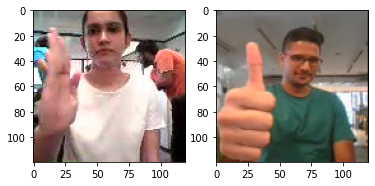

In [ ]:
# plot generated sample images
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(sample_batch_data[0,29,:,:,:])   
axes[1].imshow(sample_batch_data[3,29,:,:,:])
plt.show()

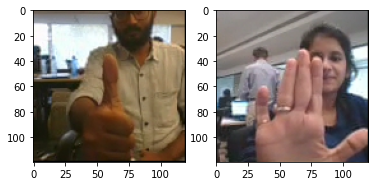

In [ ]:
# plot generated sample images
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(sample_val_batch_data[0,29,:,:,:])   
axes[1].imshow(sample_val_batch_data[3,29,:,:,:])
plt.show()

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Following Models have been run as part of the experimentation with different architechture and different hyperparameters tuning.
### 1. Base Model

In [12]:
# A base model to ust check the model is executing properly using generator.

def define_model():
    filtersize = [8,16,32,64]
    dense_neurons = [256, 128, 5]
    
    # Input
    input_shape=(total_frames,image_width,image_height,channels)
    # Define model
    model = Sequential()

    model.add(Conv3D(filtersize[0], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling3D(pool_size=(2,2,2)))

    model.add(Conv3D(filtersize[1], 
                 kernel_size=(3,3,3), 
                 padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling3D(pool_size=(2,2,2)))

    model.add(Conv3D(filtersize[2], 
                 kernel_size=(1,3,3), 
                 padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling3D(pool_size=(2,2,2)))

    #Flatten Layers
    model.add(Flatten())

    model.add(Dense(dense_neurons[1], activation='relu'))

    #softmax layer
    model.add(Dense(dense_neurons[2], activation='softmax'))

    optimiser = 'adam' #write your optimizer
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [13]:
base_model=define_model()
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 120, 120, 8)   656       
                                                                 
 batch_normalization (BatchN  (None, 30, 120, 120, 8)  32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 30, 120, 120, 8)   0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 60, 60, 8)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 60, 60, 16)    3472      
                                                                 
 batch_normalization_1 (Batc  (None, 15, 60, 60, 16)   6

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [64]:
train_generator = generator(train_path, train_doc, batch_size, augument_false=True)
val_generator = generator(val_path, val_doc, batch_size, augument_false=True)

In [65]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# write the Reducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

In [66]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

### Testing the GPU utility: Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [ ]:
# execution of the sample model
#batch_size = 512
#num_epochs = 10
#train_generator = generator(train_path, train_doc, batch_size, augument_false=True)
#val_generator = generator(val_path, val_doc, batch_size, augument_false=True)

#print("Total Params:", base_model.count_params())
#history_model_base =base_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
#                    callbacks=callbacks_list, validation_data=val_generator, 
#                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Total Params: 847461
Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 512


We had hit the limit on memory resources with batch_size of 512, we get the below error.

ResourceExhaustedError: OOM when allocating tensor with shape[512,30,30,120,120] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc

#### Inference :  
- We tried with lower batch size and go on increasing the bacth size till it says out of resource.


#### Lets start excuting with lower batch size = 10 and low epoch =10

In [17]:
# execution of the sample model
batch_size = 10
num_epochs = 10

train_generator = generator(train_path, train_doc, batch_size, augument_false=True)
val_generator = generator(val_path, val_doc, batch_size, augument_false=True)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

print("Total Params:", base_model.count_params())
history_model1 =base_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Total Params: 2774565
Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 10
Epoch 1/10
67/67 [==============================] - ETA: 0s - loss: 6.3938 - categorical_accuracy: 0.4268  Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 10

Epoch 00001: saving model to model_init_2021-11-1508_27_56.071797/model-00001-6.39378-0.42685-1.57512-0.38000.h5
67/67 [==============================] - 5646s 85s/step - loss: 6.3938 - categorical_accuracy: 0.4268 - val_loss: 1.5751 - val_categorical_accuracy: 0.3800 - lr: 0.0010
Epoch 2/10
67/67 [==============================] - ETA: 0s - loss: 1.0468 - categorical_accuracy: 0.6766
Epoch 00002: saving model to model_init_2021-11-1508_27_56.071797/model-00002-1.04681-0.67662-2.36799-0.28000.h5
67/67 [==============================] - 47s 711ms/step - loss: 1.0468 - categorical_accuracy: 0.6766 - val_loss: 2.3680 - val_categorical_accuracy: 0.2800 - lr: 0.0010
Epoch 3/10
67/67 [==============================] - 

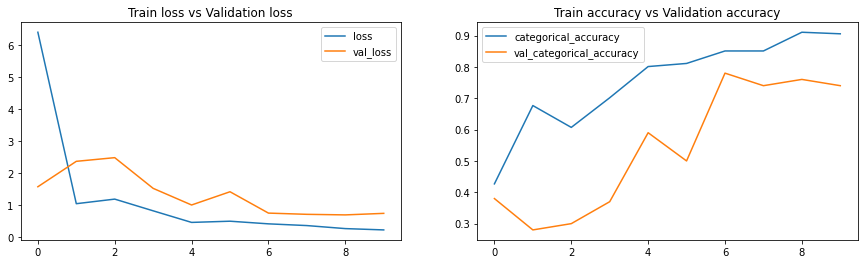

In [18]:
# plot the score
plot(history_model1)

#### Insights: We can see a big difference in the train and validation, a clear overfitting. Lets add some augmented data and verify , if that fix it.

### 2. Base Model

In [ ]:
batch_size = 10
num_epochs = 15


train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size, augument_false=True)


if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

print("Total Params:", base_model.count_params())
history_model2 =base_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Total Params: 2774565
Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 10
Epoch 1/15
67/67 [==============================] - ETA: 0s - loss: 1.0251 - categorical_accuracy: 0.5633Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 10

Epoch 00001: saving model to model_init_2021-11-1318_25_26.343274/model-00001-1.02512-0.56335-0.77602-0.76000.h5
67/67 [==============================] - 123s 2s/step - loss: 1.0251 - categorical_accuracy: 0.5633 - val_loss: 0.7760 - val_categorical_accuracy: 0.7600 - lr: 2.5000e-04
Epoch 2/15
67/67 [==============================] - ETA: 0s - loss: 0.8984 - categorical_accuracy: 0.5572
Epoch 00002: saving model to model_init_2021-11-1318_25_26.343274/model-00002-0.89843-0.55721-0.51209-0.80000.h5
67/67 [==============================] - 52s 786ms/step - loss: 0.8984 - categorical_accuracy: 0.5572 - val_loss: 0.5121 - val_categorical_accuracy: 0.8000 - lr: 2.5000e-04
Epoch 3/15
67/67 [==============================

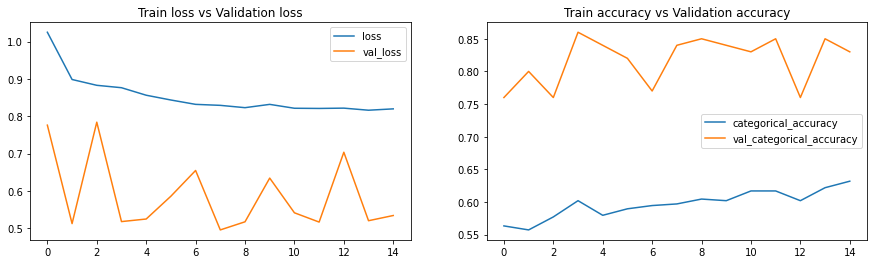

In [ ]:
# plot the score
plot(history_model2)

#### Insights:
Data augmentation does not help here, so futher we will not use the augmented data in any of the model in this case study.

Let tune the model by updating the model by reducing the filter size.

### Lets Reduce the filter Size to (2,2,2), to see if that improve the performace.

### 3. Base Model

In [ ]:
def define_model():
    filtersize = [8,16,32,64]
    dense_neurons = [256, 128, 5]
    
    # Input
    input_shape=(total_frames,image_width,image_height,channels)
    # Define model
    model = Sequential()

    model.add(Conv3D(filtersize[0], 
                 kernel_size=(2,2,2), 
                 input_shape=input_shape,
                 padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling3D(pool_size=(2,2,2)))

    model.add(Conv3D(filtersize[1], 
                 kernel_size=(2,2,2), 
                 padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling3D(pool_size=(2,2,2)))

    model.add(Conv3D(filtersize[2], 
                 kernel_size=(1,3,3), 
                 padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling3D(pool_size=(2,2,2)))


    #Flatten Layers
    model.add(Flatten())

    model.add(Dense(dense_neurons[0], activation='relu'))
    
    
    model.add(Dense(dense_neurons[1], activation='relu'))
    model.add(Dropout(0.25))

    #softmax layer
    model.add(Dense(dense_neurons[2], activation='softmax'))

    optimiser = 'adam' #write your optimizer
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model

In [ ]:
conv_3d1_model0=define_model()
conv_3d1_model0.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_7 (Conv3D)           (None, 30, 120, 120, 8)   200       
                                                                 
 batch_normalization_6 (Batc  (None, 30, 120, 120, 8)  32        
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 30, 120, 120, 8)   0         
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 15, 60, 60, 8)    0         
 3D)                                                             
                                                                 
 conv3d_8 (Conv3D)           (None, 15, 60, 60, 16)    1040      
                                                                 
 batch_normalization_7 (Batc  (None, 15, 60, 60, 16)  

In [ ]:

batch_size = 10
num_epochs = 15


train_generator = generator(train_path, train_doc, batch_size, augument_false=True)
val_generator = generator(val_path, val_doc, batch_size, augument_false=True)


if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

print("Total Params:", base_model.count_params())
history_model3 =conv_3d1_model0.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Total Params: 2774565
Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 10
Epoch 1/15
67/67 [==============================] - ETA: 0s - loss: 4.1203 - categorical_accuracy: 0.4133Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 10

Epoch 00001: saving model to model_init_2021-11-1318_25_26.343274/model-00001-4.12032-0.41327-1.67714-0.22000.h5
67/67 [==============================] - 127s 2s/step - loss: 4.1203 - categorical_accuracy: 0.4133 - val_loss: 1.6771 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/15
67/67 [==============================] - ETA: 0s - loss: 1.2105 - categorical_accuracy: 0.5572
Epoch 00002: saving model to model_init_2021-11-1318_25_26.343274/model-00002-1.21048-0.55721-2.23167-0.14000.h5
67/67 [==============================] - 54s 817ms/step - loss: 1.2105 - categorical_accuracy: 0.5572 - val_loss: 2.2317 - val_categorical_accuracy: 0.1400 - lr: 0.0010
Epoch 3/15
67/67 [==============================] - ETA:

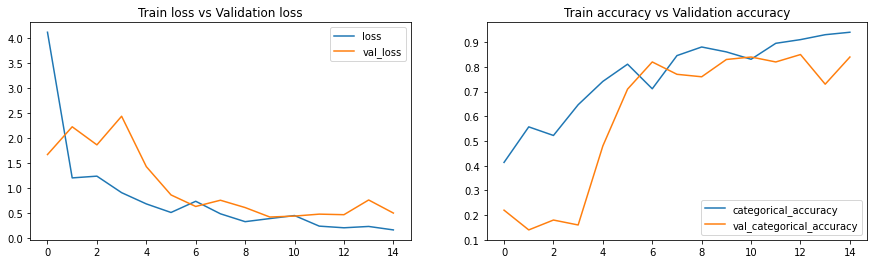

In [ ]:
plot(history_model3)

#### Insights: 
- Reducing kernel size from (3,3,3) to (2,2,2) increase the depth of the network a bit and thus improve the performance a bit.

- Let tune the model by updating the model by adding more layers, dropout, reducing parameters and tuning hyperparameters.

## 4. Model1  : CNN CONV3D
Let tune the model by updating the model by adding more layers, dropout, reducing parameters and tuning hyperparameters. Batch Size = 10,  and No. of Epochs = 40

In [67]:
def define_model():
    filtersize = [8,16,32,64]
    dense_neurons = [256, 128, 5]
    
    # Input
    input_shape=(total_frames,image_width,image_height,channels)
    # Define model
    model = Sequential()

    model.add(Conv3D(filtersize[0], 
                 kernel_size=(3,3,3), 
                 input_shape=input_shape,
                 padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling3D(pool_size=(2,2,2)))

    model.add(Conv3D(filtersize[1], 
                 kernel_size=(3,3,3), 
                 padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling3D(pool_size=(2,2,2)))

    model.add(Conv3D(filtersize[2], 
                 kernel_size=(1,3,3), 
                 padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling3D(pool_size=(2,2,2)))

    model.add(Conv3D(filtersize[3], 
                 kernel_size=(1,3,3), 
                 padding='same'))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(MaxPooling3D(pool_size=(2,2,2)))

    #Flatten Layers
    model.add(Flatten())

    model.add(Dense(dense_neurons[0], activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(dense_neurons[1], activation='relu'))
    model.add(Dropout(0.5))

    #softmax layer
    model.add(Dense(dense_neurons[2], activation='softmax'))

    optimiser = 'adam' #write your optimizer
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model


In [68]:
conv_3d1_model=define_model()
conv_3d1_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_15 (Conv3D)          (None, 30, 120, 120, 8)   656       
                                                                 
 batch_normalization_12 (Bat  (None, 30, 120, 120, 8)  32        
 chNormalization)                                                
                                                                 
 activation_15 (Activation)  (None, 30, 120, 120, 8)   0         
                                                                 
 max_pooling3d_15 (MaxPoolin  (None, 15, 60, 60, 8)    0         
 g3D)                                                            
                                                                 
 conv3d_16 (Conv3D)          (None, 15, 60, 60, 16)    3472      
                                                                 
 batch_normalization_13 (Bat  (None, 15, 60, 60, 16)  

In [69]:

batch_size = 10
num_epochs = 40

train_generator = generator(train_path, train_doc, batch_size, augument_false=True)
val_generator = generator(val_path, val_doc, batch_size, augument_false=True)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

print("Total Params:", conv_3d1_model.count_params())
history_model4 =conv_3d1_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Total Params: 864101
Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 10
Epoch 1/40
67/67 [==============================] - ETA: 0s - loss: 1.9429 - categorical_accuracy: 0.2097Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 10

Epoch 00001: saving model to model_init_2021-11-1511_29_39.141580/model-00001-1.94287-0.20965-1.60684-0.21000.h5
67/67 [==============================] - 112s 2s/step - loss: 1.9429 - categorical_accuracy: 0.2097 - val_loss: 1.6068 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/40
67/67 [==============================] - ETA: 0s - loss: 1.5887 - categorical_accuracy: 0.2388
Epoch 00002: saving model to model_init_2021-11-1511_29_39.141580/model-00002-1.58873-0.23881-1.60535-0.19000.h5
67/67 [==============================] - 47s 710ms/step - loss: 1.5887 - categorical_accuracy: 0.2388 - val_loss: 1.6054 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/40
67/67 [==============================] - ETA: 

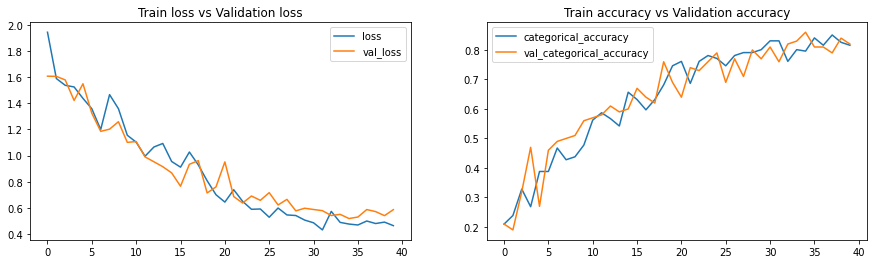

In [70]:
plot(history_model4)

#### Insights: From the accuracy score, loss value and the plot, we can say this model is doing decent.

Let now try the next model by switching model architecture to Conv2D + LSTM

## 5. Model2 : Conv2D+LSTM

In [ ]:
def define_model(lstm_cells=128,dense_neurons=128,dropout=0.5):
      
        inputshape=(total_frames,image_width,image_height,channels)
        model = Sequential()
        
        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=inputshape))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        
        model.add(TimeDistributed(Flatten()))
        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(5, activation='softmax'))
        optimiser = keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model


In [ ]:
# RNN CNN MODEL SUMMARY
rnn_cnn1_model=define_model()
rnn_cnn1_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_64 (TimeDi  (None, 30, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_65 (TimeDi  (None, 30, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_66 (TimeDi  (None, 30, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_67 (TimeDi  (None, 30, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_68 (TimeDi  (None, 30, 60, 60, 32)  

In [ ]:

batch_size = 10
num_epochs = 30

train_generator = generator(train_path, train_doc, batch_size, augument_false=True)
val_generator = generator(val_path, val_doc, batch_size, augument_false=True)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

print("Total Params:", rnn_cnn1_model.count_params())
history_model5=rnn_cnn1_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Total Params: 1657445
Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 10
Epoch 1/30
67/67 [==============================] - ETA: 0s - loss: 1.6386 - categorical_accuracy: 0.2926 Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 10

Epoch 00001: saving model to model_init_2021-11-1215_27_21.680538/model-00001-1.63856-0.29261-1.73308-0.21000.h5
67/67 [==============================] - 3600s 54s/step - loss: 1.6386 - categorical_accuracy: 0.2926 - val_loss: 1.7331 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/30
67/67 [==============================] - ETA: 0s - loss: 1.5515 - categorical_accuracy: 0.3085
Epoch 00002: saving model to model_init_2021-11-1215_27_21.680538/model-00002-1.55152-0.30846-1.72241-0.19000.h5
67/67 [==============================] - 222s 3s/step - loss: 1.5515 - categorical_accuracy: 0.3085 - val_loss: 1.7224 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/30
67/67 [==============================] - ETA

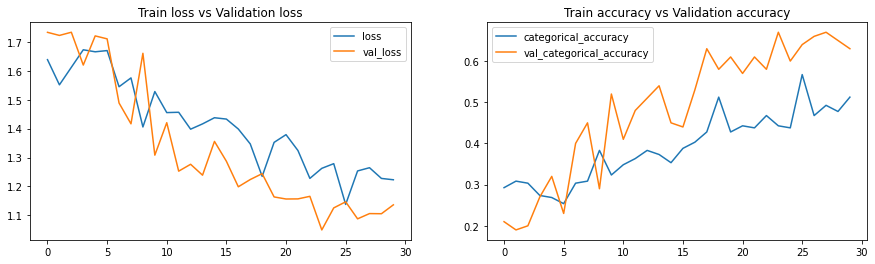

In [ ]:
plot(history_model5)

#### Insights: Don’t see much performance improvement.  

Lets try CNN LSTM with GRU

## 6. Model3  : CONV2D with GRU


In [ ]:
def define_model(lstm_cells,dense_neurons,dropout):
        
        inputshape=(total_frames,image_width,image_height,channels)
        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=inputshape))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
        model.add(TimeDistributed(Flatten()))
        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        model.add(Dense(5, activation='softmax'))
        
        optimiser = keras.optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:

rnn_cnn2_model=define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_80 (TimeDi  (None, 30, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_81 (TimeDi  (None, 30, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_82 (TimeDi  (None, 30, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_83 (TimeDi  (None, 30, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_84 (TimeDi  (None, 30, 60, 60, 32)  

In [ ]:

batch_size = 10
num_epochs = 25

train_generator = generator(train_path, train_doc, batch_size, augument_false=True)
val_generator = generator(val_path, val_doc, batch_size, augument_false=True)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

print("Total Params:", rnn_cnn2_model.count_params())
history_model6=rnn_cnn2_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)


Total Params: 2573925
Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 10
Epoch 1/25
67/67 [==============================] - ETA: 0s - loss: 1.3501 - categorical_accuracy: 0.4329Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 10

Epoch 00001: saving model to model_init_2021-11-1215_27_21.680538/model-00001-1.35014-0.43288-1.83896-0.18000.h5
67/67 [==============================] - 546s 8s/step - loss: 1.3501 - categorical_accuracy: 0.4329 - val_loss: 1.8390 - val_categorical_accuracy: 0.1800 - lr: 2.0000e-04
Epoch 2/25
67/67 [==============================] - ETA: 0s - loss: 1.0798 - categorical_accuracy: 0.6119
Epoch 00002: saving model to model_init_2021-11-1215_27_21.680538/model-00002-1.07983-0.61194-1.92298-0.19000.h5
67/67 [==============================] - 224s 3s/step - loss: 1.0798 - categorical_accuracy: 0.6119 - val_loss: 1.9230 - val_categorical_accuracy: 0.1900 - lr: 2.0000e-04
Epoch 3/25
67/67 [==============================] 

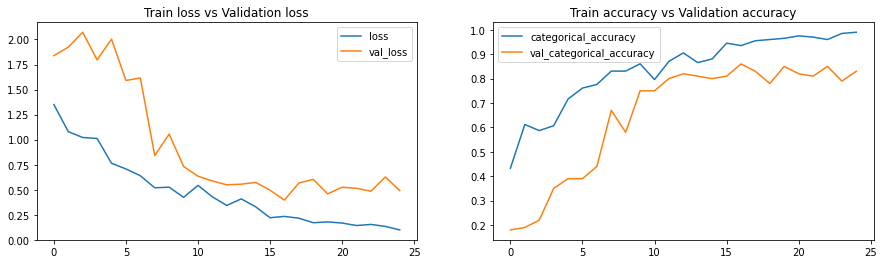

In [ ]:
plot(history_model6)

#### Insights:   
The training accuracy is 99 %, whereas the validation accuracy is 83%, the score is very good, but there is a difference of around 15 %. Hence it might be a reason of overfitting.

## 7. Model4 : Transfer Learning (MobileNet) with LSTM

In [ ]:
# importing the MobileNet model due to it's lightweight architecture and high speed performance as compared 
# to other heavy-duty models like VGG16, Alexnet, InceptionV3 etc. Also, we are now also running on low disk space 
from keras.applications import mobilenet
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

def define_model(lstm_cells=64,dense_neurons=64,dropout=0.25):
        #inputshape=(len(img_arr[0]), img_arr[1], img_arr[2], img_arr[3])
        inputshape=(total_frames,image_width,image_height,channels)
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=inputshape))
        
        
        for layer in model.layers:
            layer.trainable = False
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(5, activation='softmax'))
        
        
        optimiser = keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

17235968/17225924 [==============================] - 0s 0us/step


In [ ]:

rnn_cnn_tl_model=define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_93 (TimeDi  (None, 30, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_94 (TimeDi  (None, 30, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_95 (TimeDi  (None, 30, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_96 (TimeDi  (None, 30, 1024)         0         
 stributed)                                                      
                                                                 
 lstm_5 (LSTM)               (None, 128)              

In [ ]:


batch_size = 10
num_epochs = 25

train_generator = generator(train_path, train_doc, batch_size, augument_false=True)
val_generator = generator(val_path, val_doc, batch_size, augument_false=True)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

print("Total Params:", rnn_cnn_tl_model.count_params())
history_model7=rnn_cnn_tl_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Total Params: 3840453
Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 10
Epoch 1/25
67/67 [==============================] - ETA: 0s - loss: 1.2189 - categorical_accuracy: 0.5053Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 10

Epoch 00001: saving model to model_init_2021-11-1215_27_21.680538/model-00001-1.21886-0.50528-0.83366-0.67000.h5
67/67 [==============================] - 327s 5s/step - loss: 1.2189 - categorical_accuracy: 0.5053 - val_loss: 0.8337 - val_categorical_accuracy: 0.6700 - lr: 0.0010
Epoch 2/25
67/67 [==============================] - ETA: 0s - loss: 0.9013 - categorical_accuracy: 0.6766
Epoch 00002: saving model to model_init_2021-11-1215_27_21.680538/model-00002-0.90125-0.67662-0.66692-0.75000.h5
67/67 [==============================] - 131s 2s/step - loss: 0.9013 - categorical_accuracy: 0.6766 - val_loss: 0.6669 - val_categorical_accuracy: 0.7500 - lr: 0.0010
Epoch 3/25
67/67 [==============================] - ETA: 0

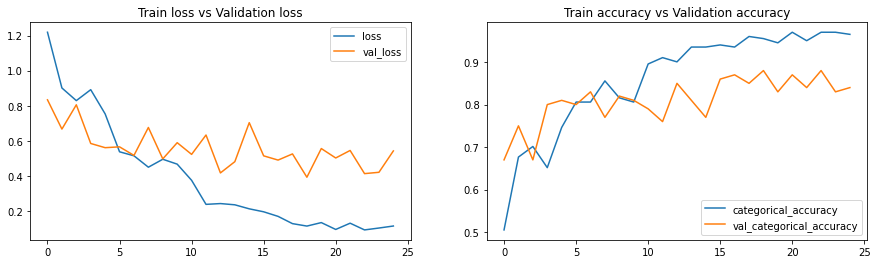

In [ ]:
plot(history_model7)

#### Insights:  
After transfer learning, we can see that the train accuracy has come don 3 %, where as the validation accuracy increased by 1 %. There is a little improvement from the last CNN + RRN GRU model score.

## 8. Model5  - Transfer Learning Mobilenet with GRU and training all weights

In [ ]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

    
def define_model(gru_cells=64,dense_neurons=64,dropout=0.25):
        inputshape=(total_frames,image_width,image_height,channels)
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(inputshape)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(5, activation='softmax'))

        optimiser = keras.optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model
        
        

17235968/17225924 [==============================] - 0s 0us/step


In [ ]:

rnn_cnn_tl2_model=define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl2_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 3, 3, 1024)   3228864   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 1024)         0         
 tributed)                                                       
                                                                 
 gru (GRU)                   (None, 128)              

In [ ]:
batch_size = 10
num_epochs = 25

train_generator = generator(train_path, train_doc, batch_size, augument_false=True)
val_generator = generator(val_path, val_doc, batch_size, augument_false=True)

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1


print("Total Params:", rnn_cnn_tl2_model.count_params())
history_model8=rnn_cnn_tl2_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Total Params: 3693253
Source path =  /content/drive/MyDrive/Project_data/train ; batch size = 10
Epoch 1/25
67/67 [==============================] - ETA: 0s - loss: 0.8578 - categorical_accuracy: 0.6833 Source path =  /content/drive/MyDrive/Project_data/val ; batch size = 10

Epoch 00001: saving model to model_init_2021-11-1406_10_51.625117/model-00001-0.85776-0.68326-0.54034-0.80000.h5
67/67 [==============================] - 1452s 22s/step - loss: 0.8578 - categorical_accuracy: 0.6833 - val_loss: 0.5403 - val_categorical_accuracy: 0.8000 - lr: 0.0010
Epoch 2/25
67/67 [==============================] - ETA: 0s - loss: 0.6797 - categorical_accuracy: 0.7761
Epoch 00002: saving model to model_init_2021-11-1406_10_51.625117/model-00002-0.67965-0.77612-1.35455-0.53000.h5
67/67 [==============================] - 463s 7s/step - loss: 0.6797 - categorical_accuracy: 0.7761 - val_loss: 1.3546 - val_categorical_accuracy: 0.5300 - lr: 0.0010
Epoch 3/25
67/67 [==============================] - ETA

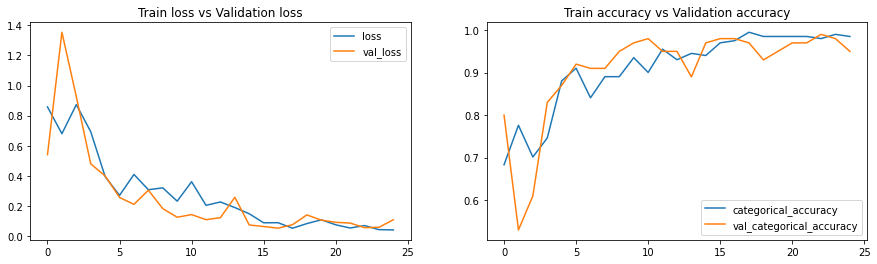

In [ ]:
plot(history_model8)

#### Insights: 
Excellent score! 98.5% Training accuracy and 95% validation accuracy 

## Conclusion:   

After doing all the experiments, we finalized Model 4 - CNN CONV3D, which performed well.
Reason:

- (Training Accuracy : 81.59, Validation Accuracy : 82%)

- Number of Parameters(864,101) which is far less than other models in the experiment.

- The best weights of CNN-CONV3D: model_init_2021-11-1511_29_39.141580/model-00040-0.46377-0.81592-0.58616-0.82000.h5

In [71]:
import shutil 
source= "/content/model_init_2021-11-1511_29_39.141580/model-00040-0.46377-0.81592-0.58616-0.82000.h5"
destination= "/content/drive/MyDrive"
dest = shutil.move(source, destination) 

print("After moving file:") 
 
# Print path of newly 
# created file 
print("Destination path:", dest) 

After moving file:
Destination path: /content/drive/MyDrive/model-00040-0.46377-0.81592-0.58616-0.82000.h5
